# Recurrent Neural Networks

Classical neural networks, including convolutional ones, suffer from two severe limitations:

+ They only accept a fixed-sized vector as input and produce a fixed-sized vector as output.
+ They do not consider the sequential nature of some data (language, video frames, time series, etc.)

Recurrent neural networks overcome these limitations by allowing to operate over sequences of vectors (in the input, in the output, or both).

RNN can be interpreted as running a fixed program (consisting of a recurrent transformation that can be applied as many times as we like) with certain inputs and certain internal variables.

## Learning to add

Source: http://projects.rajivshah.com/blog/2016/04/05/rnn_addition/ 

The objective of this code developed by Rajiv Shah is to train a RNN for adding a sequence of integers.

In [30]:
# Import basic libraries
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import rnn_cell
from tensorflow.python.ops import rnn
from tensorflow.python.ops import seq2seq
from numpy import sum
import matplotlib.pyplot as plt
from tqdm import *
%matplotlib inline  
tf.reset_default_graph()

We will define first a set of hyperparameters, being the most important ``num_units``, that is the parameter that represents the internal memory in the basic LSTM cell.

In [31]:
num_units = 50  
input_size = 1      
batch_size = 50    
seq_len = 7
drop_out = 0.6 

Then, we can write an auxiliar function to generate random sequences of integers (and the result of their addition):

In [32]:
# Creates our random sequences
def gen_data(min_length=5, max_length=15, n_batch=50):

    X = np.concatenate([np.random.randint(10,size=(n_batch, max_length, 1))],
                       axis=-1)
    y = np.zeros((n_batch,))
    # Compute masks and correct values
    for n in range(n_batch):
        # Randomly choose the sequence length
        length = np.random.randint(min_length, max_length)
        X[n, length:, 0] = 0
        # Sum the dimensions of X to get the target value
        y[n] = np.sum(X[n, :, 0]*1)
    return (X,y)

print gen_data(2,5,1)

(array([[[0],
        [4],
        [0],
        [0],
        [0]]]), array([ 4.]))


Now we are ready to star the model construction phase:

In [33]:
# Model architecture
num_layers = 2
cell = rnn_cell.BasicLSTMCell(num_units)
cell = rnn_cell.MultiRNNCell([cell] * num_layers)
cell = rnn_cell.DropoutWrapper(cell,output_keep_prob=drop_out)

# Create placeholders for X and y
inputs = [tf.placeholder(tf.float32,shape=[batch_size,1]) for _ in range(seq_len)]
result = tf.placeholder(tf.float32, shape=[batch_size])

# We initialize the initial cell state to 0
initial_state = cell.zero_state(batch_size, tf.float32)
outputs, states = seq2seq.rnn_decoder(inputs, initial_state, cell, scope ='rnnln')

# We are only interested in the final LSTM output value
outputs2 = outputs[-1]

# Tranformation of the final LSTM output value to a real value
W_o = tf.Variable(tf.random_normal([num_units,input_size], stddev=0.01))     
b_o = tf.Variable(tf.random_normal([input_size], stddev=0.01))
outputs3 = tf.matmul(outputs2, W_o) + b_o

# Definition of the mean square loss function
cost = tf.pow(tf.sub(tf.reshape(outputs3, [-1]), result),2)
train_op = tf.train.RMSPropOptimizer(0.005, 0.2).minimize(cost) 

In [34]:
### Generate Validation Data
tempX,y_val = gen_data(5,seq_len,batch_size)
X_val = []
for i in range(seq_len):
    X_val.append(tempX[:,i,:])

In [35]:
##Session
sess = tf.Session()
sess.run(tf.initialize_all_variables())
train_score =[]
val_score= []
x_axis=[]

In [36]:
num_epochs=10000
 
for k in tqdm(range(1,num_epochs)):

    #Generate Data for each epoch
    tempX,y = gen_data(5,seq_len,batch_size)
    X = []
    for i in range(seq_len):
        X.append(tempX[:,i,:])

    #Create the dictionary of inputs to feed into sess.run
    temp_dict = {inputs[i]:X[i] for i in range(seq_len)}
    temp_dict.update({result: y})

    _,c_train = sess.run([train_op,cost],feed_dict=temp_dict)   #perform an update on the parameters

    val_dict = {inputs[i]:X_val[i] for i in range(seq_len)}  #create validation dictionary
    val_dict.update({result: y_val})
    c_val = sess.run([cost],feed_dict = val_dict )            #compute the cost on the validation set
    if (k%100==0):
        train_score.append(sum(c_train))
        val_score.append(sum(c_val))
        x_axis.append(k)

100%|██████████| 9999/9999 [02:50<00:00, 58.79it/s]


Final Train cost: 222.095123291, on Epoch 9999
Final Validation cost: 229.60244751, on Epoch 9999


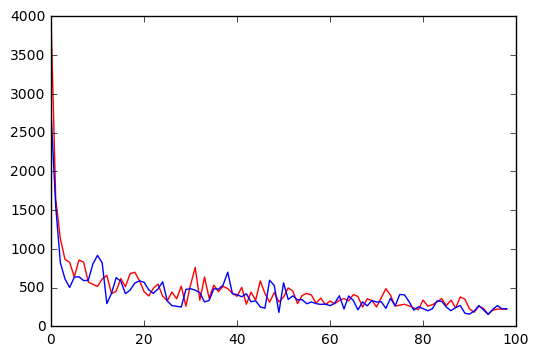

In [37]:
print "Final Train cost: {}, on Epoch {}".format(train_score[-1],k)
print "Final Validation cost: {}, on Epoch {}".format(val_score[-1],k)
plt.plot(train_score, 'r-', val_score, 'b-')
plt.show()

In [38]:
##This part generates a new validation set to test against
val_score_v =[]
num_epochs=1

for k in range(num_epochs):

    #Generate Data for each epoch
    tempX,y = gen_data(5,seq_len,batch_size)
    X = []
    for i in range(seq_len):
        X.append(tempX[:,i,:])

    val_dict = {inputs[i]:X[i] for i in range(seq_len)}
    val_dict.update({result: y})
    outv, c_val = sess.run([outputs3,cost],feed_dict = val_dict ) 
    val_score_v.append([c_val])


In [39]:
##Target
tempX[3],y[3]

(array([[4],
        [4],
        [0],
        [3],
        [5],
        [6],
        [0]]), 22.0)

In [40]:
#Prediction
outv[3]

array([ 21.57432556], dtype=float32)

## Example

A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.

This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/

In [46]:
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import numpy as np
tf.reset_default_graph()

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


To classify images using a recurrent neural network, we consider every image row as a sequence of pixels. Because MNIST image shape is $28 \times 28$ px, we will then handle 28 sequences of 28 steps for every sample.

In [47]:
# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128

display_step = 50

# Network Parameters
n_input = 28 # number of sequences for every sample
n_steps = 28 # number of timesteps for every sequence
n_hidden = 64 # hidden layer num of features
n_classes = 10 # total classes (0-9 digits)

In [48]:
# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])

# Tensorflow LSTM cell requires 2x n_hidden length (state & cell)
istate = tf.placeholder("float", [None, 2*n_hidden])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), 
    # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [49]:
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

In [51]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc)
        step += 1
    print "Optimization Finished!"

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print "Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label})

Iter 6400, Minibatch Loss= 1.029582, Training Accuracy= 0.70312
Iter 12800, Minibatch Loss= 0.575474, Training Accuracy= 0.80469
Iter 19200, Minibatch Loss= 0.328122, Training Accuracy= 0.90625
Iter 25600, Minibatch Loss= 0.369917, Training Accuracy= 0.88281
Iter 32000, Minibatch Loss= 0.159932, Training Accuracy= 0.96094
Iter 38400, Minibatch Loss= 0.277152, Training Accuracy= 0.90625
Iter 44800, Minibatch Loss= 0.398959, Training Accuracy= 0.89844
Iter 51200, Minibatch Loss= 0.182146, Training Accuracy= 0.96094
Iter 57600, Minibatch Loss= 0.198010, Training Accuracy= 0.92969
Iter 64000, Minibatch Loss= 0.156422, Training Accuracy= 0.96094
Iter 70400, Minibatch Loss= 0.171092, Training Accuracy= 0.95312
Iter 76800, Minibatch Loss= 0.147238, Training Accuracy= 0.95312
Iter 83200, Minibatch Loss= 0.221436, Training Accuracy= 0.93750
Iter 89600, Minibatch Loss= 0.088466, Training Accuracy= 0.96875
Iter 96000, Minibatch Loss= 0.198219, Training Accuracy= 0.94531
Optimization Finished!
Tes

## Bidirectional LSTM

In [1]:
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import numpy as np

tf.reset_default_graph()

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    # Hidden layer weights => 2*n_hidden because of foward + backward cells
    'out': tf.Variable(tf.random_normal([2*n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
def BiRNN(x, weights, biases):

    # Prepare data shape to match `bidirectional_rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshape to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # Define lstm cells with tensorflow
    # Forward direction cell
    lstm_fw_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # Backward direction cell
    lstm_bw_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    try:
        outputs, _, _ = rnn.bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                              dtype=tf.float32)
    except Exception: # Old TensorFlow version only returns outputs not states
        outputs = rnn.bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                        dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

In [3]:
pred = BiRNN(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc)
        step += 1
    print "Optimization Finished!"

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print "Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label})

Iter 1280, Minibatch Loss= 1.860956, Training Accuracy= 0.33594
Iter 2560, Minibatch Loss= 1.668990, Training Accuracy= 0.42188
Iter 3840, Minibatch Loss= 1.267687, Training Accuracy= 0.52344
Iter 5120, Minibatch Loss= 0.979197, Training Accuracy= 0.66406
Iter 6400, Minibatch Loss= 0.840010, Training Accuracy= 0.69531
Iter 7680, Minibatch Loss= 1.150313, Training Accuracy= 0.62500
Iter 8960, Minibatch Loss= 0.872970, Training Accuracy= 0.72656
Iter 10240, Minibatch Loss= 0.687948, Training Accuracy= 0.78125
Iter 11520, Minibatch Loss= 0.468093, Training Accuracy= 0.89062
Iter 12800, Minibatch Loss= 0.747362, Training Accuracy= 0.75781
Iter 14080, Minibatch Loss= 0.563014, Training Accuracy= 0.81250
Iter 15360, Minibatch Loss= 0.393497, Training Accuracy= 0.85938
Iter 16640, Minibatch Loss= 0.453522, Training Accuracy= 0.88281
Iter 17920, Minibatch Loss= 0.321291, Training Accuracy= 0.87500
Iter 19200, Minibatch Loss= 0.237412, Training Accuracy= 0.94531
Iter 20480, Minibatch Loss= 0.16

## Names (tflearn)


In [8]:
from __future__ import absolute_import, division, print_function

import tflearn, time, tensorflow

tensorflow.reset_default_graph()

def textfile_to_seq(file, seq_maxlen=25, redun_step=3):
    """ string_to_semi_redundant_sequences.
    Vectorize a string and returns parsed sequences and targets, along with
    the associated dictionary.
    Arguments:
        string: `str`. Lower-case text from input text file.
        seq_maxlen: `int`. Maximum length of a sequence. Default: 25.
        redun_step: `int`. Redundancy step. Default: 3.
    Returns:
        `tuple`: (inputs, targets, dictionary)
    """
    import numpy as np
    import re
    print("Vectorizing text...")
    
    import codecs
    f = codecs.open(file, "r", "utf-8")
    string = f.read()
    string.encode('utf-8')
    string = string.lower()
    chars = set()
    chars.update(string)
    char_idx = {c: i for i, c in enumerate(chars)}

    sequences = []
    next_chars = []
    for i in range(0, len(string) - seq_maxlen, redun_step):
        sequences.append(string[i: i + seq_maxlen])
        next_chars.append(string[i + seq_maxlen])

    X = np.zeros((len(sequences), seq_maxlen, len(chars)), dtype=np.bool)
    Y = np.zeros((len(sequences), len(chars)), dtype=np.bool)
    for i, seq in enumerate(sequences):
        for t, char in enumerate(seq):
            X[i, t, char_idx[char]] = 1
        Y[i, char_idx[next_chars[i]]] = 1

    print("Text total length: " + str(len(string)))
    print("Distinct chars: " + str(len(chars)))
    print("Total sequences: " + str(len(sequences)))
    return X, Y, char_idx

def random_sequence_from_string(string, seq_maxlen):
    import random
    rand_index = random.randint(0, len(string) - seq_maxlen - 1)
    return string[rand_index: rand_index + seq_maxlen]

def random_sequence_from_textfile(path, seq_maxlen):
    import codecs
    import re
    f = codecs.open(path, "r", "utf-8")
    text = f.read()
    text.encode('utf-8')
    text = text.lower()
    return random_sequence_from_string(text, seq_maxlen)

# path = 'toponims.txt'
path = "NombresMujerBarcelona.txt"

maxlen = 20

X, Y, char_idx = \
    textfile_to_seq(path, seq_maxlen=maxlen, redun_step=2)

g = tflearn.input_data(shape=[None, maxlen, len(char_idx)])
g = tflearn.lstm(g, 64, return_seq=True)
g = tflearn.dropout(g, 0.5)
g = tflearn.lstm(g, 64)
g = tflearn.dropout(g, 0.5)
g = tflearn.fully_connected(g, len(char_idx), activation='softmax')
g = tflearn.regression(g, optimizer='adam', loss='categorical_crossentropy',
                       learning_rate=0.01)

m = tflearn.SequenceGenerator(g, dictionary=char_idx,
                              seq_maxlen=maxlen,
                              clip_gradients=5.0)

# names
for i in range(100):
    seed = random_sequence_from_textfile(path, maxlen)
    m.fit(X, Y, validation_set=0.1, batch_size=128,
          n_epoch=1, run_id='nombres')
    print(m.generate(30, temperature=1.2, seq_seed=seed).encode('utf-8'))
    time.sleep(5)

Training Step: 16632  | total loss: 0.89219
| Adam | epoch: 001 | loss: 0.89219 | val_loss: 0.71742 -- iter: 21378/21378
Training Step: 16632  | total loss: 0.89219
| Adam | epoch: 001 | loss: 0.89219 | val_loss: 0.71742 -- iter: 21378/21378
--
salut
maria salvadora
maria paula
maria paralmi
ma
---------------------------------
Run id: nombres
Log directory: /tmp/tflearn_logs/


KeyboardInterrupt: 

In [ ]:
import tflearn, time

def textfile_to_seq(file, seq_maxlen=25, redun_step=3):
    """ string_to_semi_redundant_sequences.
    Vectorize a string and returns parsed sequences and targets, along with
    the associated dictionary.
    Arguments:
        string: `str`. Lower-case text from input text file.
        seq_maxlen: `int`. Maximum length of a sequence. Default: 25.
        redun_step: `int`. Redundancy step. Default: 3.
    Returns:
        `tuple`: (inputs, targets, dictionary)
    """
    import numpy as np
    import re
    print("Vectorizing text...")
    
    import codecs
    f = codecs.open(file, "r", "utf-8")
    string = f.read()
    string.encode('utf-8')
    string = re.sub( '([A-Z])', '^\\1', string ).lower()
    chars = set()
    chars.update(string)
    char_idx = {c: i for i, c in enumerate(chars)}

    sequences = []
    next_chars = []
    for i in range(0, len(string) - seq_maxlen, redun_step):
        sequences.append(string[i: i + seq_maxlen])
        next_chars.append(string[i + seq_maxlen])

    X = np.zeros((len(sequences), seq_maxlen, len(chars)), dtype=np.bool)
    Y = np.zeros((len(sequences), len(chars)), dtype=np.bool)
    for i, seq in enumerate(sequences):
        for t, char in enumerate(seq):
            X[i, t, char_idx[char]] = 1
        Y[i, char_idx[next_chars[i]]] = 1

    print("Text total length: " + str(len(string)))
    print("Distinct chars: " + str(len(chars)))
    print("Total sequences: " + str(len(sequences)))
    return X, Y, char_idx

def random_sequence_from_string(string, seq_maxlen):
    import random
    rand_index = random.randint(0, len(string) - seq_maxlen - 1)
    return string[rand_index: rand_index + seq_maxlen]

def random_sequence_from_textfile(path, seq_maxlen):
    import codecs
    import re
    f = codecs.open(path, "r", "utf-8")
    text = f.read()
    text.encode('utf-8')
    text = re.sub( '([A-Z])', '^\\1', text ).lower()
    return random_sequence_from_string(text, seq_maxlen)

path = 'toponims.txt'

maxlen = 20

X, Y, char_idx = \
    textfile_to_seq(path, seq_maxlen=maxlen, redun_step=2)

g = tflearn.input_data(shape=[None, maxlen, len(char_idx)])
g = tflearn.lstm(g, 64, return_seq=True)
g = tflearn.dropout(g, 0.5)
g = tflearn.lstm(g, 64)
g = tflearn.dropout(g, 0.5)
g = tflearn.fully_connected(g, len(char_idx), activation='softmax')
g = tflearn.regression(g, optimizer='adam', loss='categorical_crossentropy',
                       learning_rate=0.01)

m = tflearn.SequenceGenerator(g, dictionary=char_idx,
                              seq_maxlen=maxlen,
                              clip_gradients=5.0)

for i in range(10):
    seed = random_sequence_from_textfile(path, maxlen)
    m.fit(X, Y, validation_set=0.1, batch_size=128,
          n_epoch=1, run_id='toponims')
    f = open('names.txt','wb')
    f.write("-- TESTING... \n")
    f.write("-- EPOCH = " + str(i) + "\n")
    f.write("-- Test with temperature of 1.2 -- \n")
    f.write(m.generate(30, temperature=1.2, seq_seed=seed).encode('ascii','ignore')+ "\n")
    f.write("-- Test with temperature of 1.0 -- \n")
    f.write(m.generate(30, temperature=1.0, seq_seed=seed).encode('ascii','ignore')+ "\n")
    f.write("-- Test with temperature of 0.5 -- \n")
    f.write(m.generate(30, temperature=0.5, seq_seed=seed).encode('ascii','ignore')+ "\n")
    f.close()